In [ ]:
#Quick cell to make jupyter notebook use the full screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
#Some plotting libraries
import matplotlib.pyplot as plt
%matplotlib notebook
from bokeh.plotting import show, save, output_notebook, output_file
from bokeh.resources import INLINE 
output_notebook(resources=INLINE)

In [ ]:
from src import workflow, paths
from src.data import Dataset

In [ ]:
import umap
import umap.plot
from vectorizers import NgramVectorizer

In [ ]:
beer_ds = Dataset.load("beer_by_reviewers")
beer = beer_ds.data

In [ ]:
beer.head(3).T

In [ ]:
len(beer)

## Embed the data

We are going to vectorize our data and look at the number of categorical values they have in common.  A useful thing to do here is to require each row to have a minimum support before being included.  Filtering this early, will ensure indices line up later on.

In [ ]:
popular_beer = beer[beer.review_profilename_len>50].reset_index(drop=True)

In [ ]:
len(popular_beer)

This nest step turns the list of reviewers into a sparse matrix of counts. One row per row of our data frame and one column per unique token that appeared in our categorical field of interest.

We use `min_document_occurrences=10` in our NgramVectorizer to only count reviewers who have reviewed at least 10 beers. 


In [ ]:
import numpy as np

In [ ]:
beer_by_authors_vectorizer = NgramVectorizer(min_document_occurrences=10)
beer_by_authors = beer_by_authors_vectorizer.fit_transform(popular_beer.review_profilename_list)
beer_by_authors 

Now we reduce the dimension of this data.

If we are dealing with sets (i.e. just presence or absence of a category) use:<BR>
`metric='jaccard'`<BR>
If we think counts should matter we might use:<BR>
`metric='hellinger'`<BR>
or if we want to correct for very unbalanced column frequencies:<BR>
`metric='hellinger'`<BR>
    
As you get more and more points I'd recommend increasing the `n_neighbors` parameter to compensate.  Thing of this as a resolution parameter.

`n_components` controls the dimension you will be embedding your data into (2-dimensions for easy visualization).  Feel free to embed into higher dimensions for clustering if you'd like.

`unique=True` says that if you have two identical points you want to map them to the exact same co-ordinates in your low space.  This becomes especially important if you have more exact dupes that your `n_neighbors` parameter.  That is the problem case where exact dupes can be pushed into very different regions of your space.

In [ ]:
path_to_figures = paths['project_path'] / 'reports' / 'figures'
root_filename = 'popular_beer_by_positive_reviewer_jaccard'
outfile_png = path_to_figures / (root_filename + '.png')
outfile_html = path_to_figures / (root_filename + '.html')

In [ ]:
%%time
beer_by_authors_model = umap.UMAP(n_neighbors=15, n_components=2, metric='jaccard',
                                  unique=True, random_state=42).fit(beer_by_authors.todense())

In [ ]:
umap_plot = umap.plot.points(beer_by_authors_model, labels=popular_beer.brewery_name,
                             theme='fire', show_legend=False);
#umap_plot.figure.savefig(outfile_png, dpi=300, bbox_inches='tight')

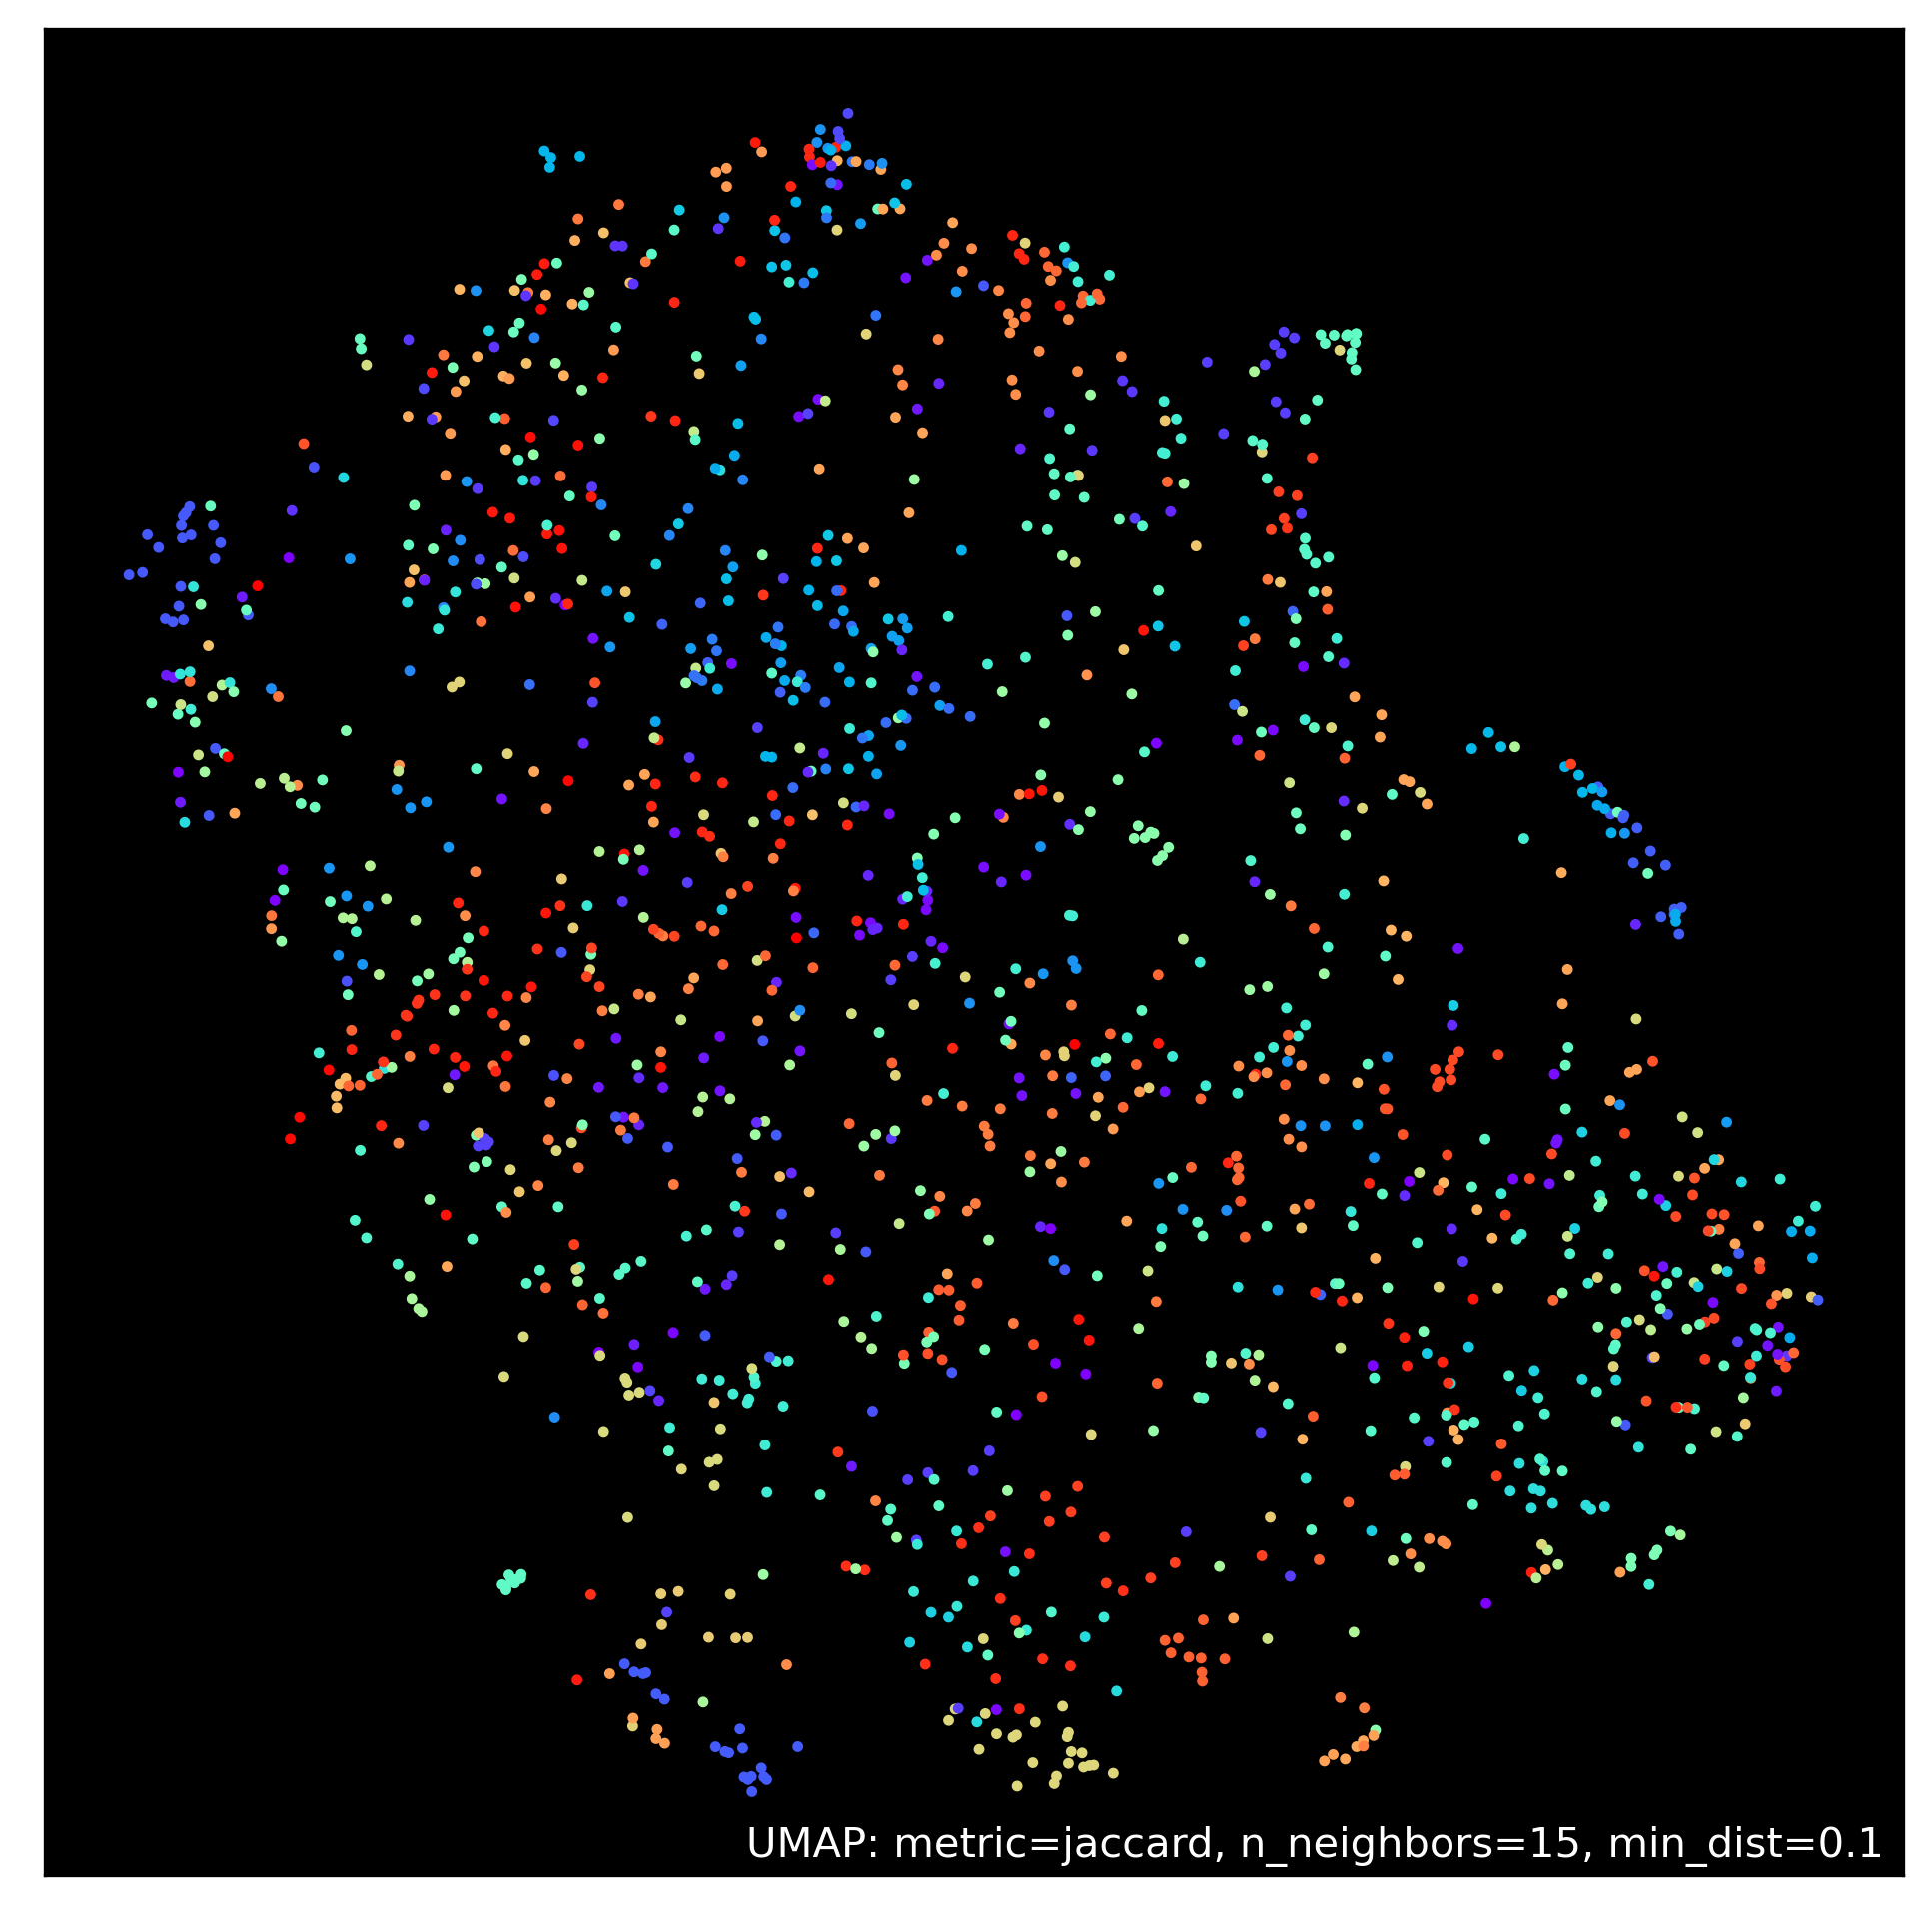

... and now for an interactive plot with mouseover.

In [ ]:
abv_label = popular_beer.beer_abv.fillna(0)
hover_df = popular_beer['beer_beerid beer_name brewery_name beer_style'.split()]
f = umap.plot.interactive(beer_by_authors_model, labels=popular_beer.brewery_name,
                          hover_data=hover_df, theme='fire', point_size=5);
#save(f, filename=outfile_html)
show(f)